<a href="https://colab.research.google.com/github/emmenets/neuralnetwork/blob/master/200613_Einfuehrung_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-06-13 06:06:02--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  14.4MB/s    in 13s     

2020-06-13 06:06:16 (12.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [4]:
!tar -xvf /content/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
class CifarLoader(object):
  def __init__(self, source_files):
    self._source = source_files
    self._i = 0
    self.images = None
    self.labels = None

  def load(self):
    data = [unpickle(f) for f in self._source]
    images = np.vstack([d[b"data"] for d in data])
    n = len(images)
    self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
    self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
    return self

  def next_batch(self, batch_size):
    x, y = self.images[self._i:self._i+batch_size], self.labels[self._i:self._i+batch_size]
    self._i = (self._i + batch_size) % len(self.images)
    return x, y


In [0]:
DATA_PATH = '/content/cifar-10-batches-py'
def unpickle(file):
  with open(os.path.join(DATA_PATH, file), 'rb') as fo:
    dict = pickle.load(fo, encoding="bytes")
  return dict

def one_hot(vec, vals=10):
  n = len(vec)
  out = np.zeros((n, vals))
  out[range(n), vec] = 1
  return out

In [0]:
class CifarDataManager(object):
  def __init__(self):
    self.train = CifarLoader(["data_batch_{}".format(i)
    for i in range(1, 6)])\
    .load()
    self.test = CifarLoader(["test_batch"]).load()


Anzahl der Bilder zum Anlernen: 50000
Anzahl der Markierungen zum Anlernen: 50000
Anzahl der Bilder zum Testen: 10000
Anzahl der Markierungen zum Testen: 10000


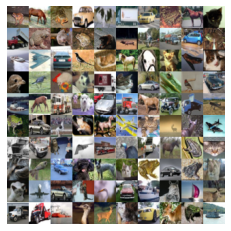

In [8]:
import pickle
def display_cifar(images, size):
  n = len(images)
  plt.figure()
  plt.gca().set_axis_off()
  im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
  plt.imshow(im)
  plt.show()



d = CifarDataManager()
print("Anzahl der Bilder zum Anlernen: {}".format(len(d.train.images)))
print("Anzahl der Markierungen zum Anlernen: {}".format(len(d.train.labels)))
print("Anzahl der Bilder zum Testen: {}".format(len(d.test.images)))
print("Anzahl der Markierungen zum Testen: {}".format(len(d.test.labels)))
images = d.train.images
display_cifar(images, 10)

In [0]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

In [0]:
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [0]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [0]:
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [0]:
def conv_layer(input, shape):
  W = weight_variable(shape)
  b = bias_variable([shape[3]])
  return tf.nn.relu(conv2d(input,W)+b)

In [0]:
def full_layer(input, size):
  in_size = int(input.get_shape()[1])
  W = weight_variable([in_size, size])
  b = bias_variable([size])
  return tf.matmul(input,W) + b

In [17]:
cifar = CifarDataManager()
STEPS = 10000
BATCH_SIZE = 1000
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv3 = conv_layer(conv2_pool, shape=[5,5,64,128])
conv3_pool = max_pool_2x2(conv3)
conv3_flat = tf. reshape(conv3_pool, [-1, 4*4*128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_flat, 512))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def test(sess):
  X = cifar.test.images.reshape(10, 1000, 32, 32,3)
  Y = cifar.test.labels.reshape(10, 1000, 10)
  acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0}) for i in range(10)])
  print("Genauigkeit: {:.4}%".format(acc*100))
zahler = 1
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(STEPS):
    batch = cifar.train.next_batch(BATCH_SIZE)
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    print(zahler)
    zahler += 1

  test(sess)


Streaming output truncated to the last 5000 lines.
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192